In [93]:
from pytraction import TractionForceConfig
from pytraction import plot, prcoess_stack

from skimage import io
import numpy as np
import matplotlib.pyplot as plt

# # # ######### Example 1
pix_per_mu = 1.3
E = 100 # Young's modulus in Pa

img_path = '../data/example1/e01_pos1_axon1.tif'
ref_path = '../data/example1/e01_pos1_axon1_ref.tif'

traction_config = TractionForceConfig(pix_per_mu, E=E)
img1, ref1, _ = traction_config.load_data(img_path, ref_path)

img_path = '../data/example2/1kPa-2-Position006.tif'
ref_path = '../data/example2/1kPa-2-Position006_ref.tif'
roi_path = '../data/example2/1kPa-2-Position006.roi'

img2, ref2, roi = traction_config.load_data(img_path, ref_path, roi_path)

img_path_bead = '../data/example3/Beads3.tif'
img_path_cell = '../data/example3/Cell3.tif'
ref_path = '../data/example3/BeadsStop.tif'

def z_project(img_path):
        img = io.imread(img_path)
        img_max= np.max(img, axis=0)
        return img_max

bead = z_project(img_path_bead)
cell = z_project(img_path_cell)
ref = z_project(ref_path)

img = np.stack([[bead, cell]])
ref = np.stack([ref, ref])

io.imsave('../data/example3/tfm.tif', img)
io.imsave('../data/example3/tfm-ref.tif', ref)


img_path = '../data/example3/tfm.tif'
ref_path = '../data/example3/tfm-ref.tif'

traction_config = TractionForceConfig(pix_per_mu, E=E, segment=True, window_size=16)

img3, ref3, roi = traction_config.load_data(img_path, ref_path)

In [131]:
import os
def read_aki_data_stacks(folder):
    files = glob.glob(f'{folder}/*.tif')

    assert files

    files = sorted(files)

    def z_project(img):
        img = io.imread(img)
        img_max= np.max(img, axis=0)
        return img_max

    tzxy_stack = []
    for file in files:
        if 'start' not in file.lower() and 'stop' not in file.lower() and 'beads' in file.lower():
            beads = file
            cell = file.replace('Beads', 'Cell')
            
            assert os.path.exists(beads)
            assert os.path.exists(cell)
            

            cell_z = io.imread(cell)[0,:,:]
            beads_z = z_project(beads)

            stack = np.stack([beads_z, cell_z])

            tzxy_stack.append(stack)
        
        if 'stop' in file.lower() and 'beads' in file.lower():
            beads = file
            cell = file.replace('Beads', 'Cell')
            
            assert os.path.exists(beads)
            assert os.path.exists(cell)
            
            print(cell, beads)

            cell_z = z_project(cell)
            beads_z = z_project(beads)

            ref = np.stack([beads_z, cell_z])

    img = np.stack(tzxy_stack)
    return img, ref 

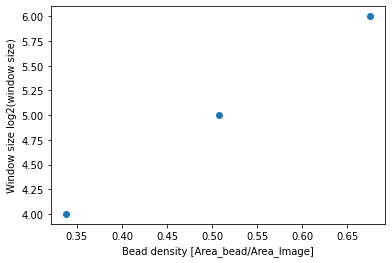

In [96]:
def density(img, window_size):
    clahe_img = clahe(normalize(img))
    norm = cv2.adaptiveThreshold(clahe_img,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,5,2)/255
    
    ones = len(norm[norm == 1])
    
    area = img.shape[0]* img.shape[1]
    area_beads = ones/area
    
    return area_beads


x = [    
density(img1[0,0,:,:], window_size=32),
density(img2[0,0,:,:], window_size=64),
density(img3[0,0,:,:], window_size=16),
]

y = [
    32,64,16
]

plt.scatter(x,np.log2(y))
plt.ylabel('Window size log2(window size)')
plt.xlabel('Bead density [Area_bead/Area_Image]')

plt.show()

In [101]:
def density(img, window_size):
    clahe_img = clahe(normalize(img))
    norm = cv2.adaptiveThreshold(clahe_img,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,5,2)/255
    
    ones = len(norm[norm == 1])
    
    area = img.shape[0]* img.shape[1]
    area_beads = ones/area
    
    return [area_beads, window_size]


x1 = np.array([density(img1[i,0,:,:], window_size=32) for i in range(img1.shape[0])])
x2 = np.array([density(img2[0,0,:,:], window_size=64) for i in range(img2.shape[0])])
x3 = np.array([density(img3[0,0,:,:], window_size=16) for i in range(img3.shape[0])])


In [106]:
x, y = np.concatenate([x1,x2,x3]).T

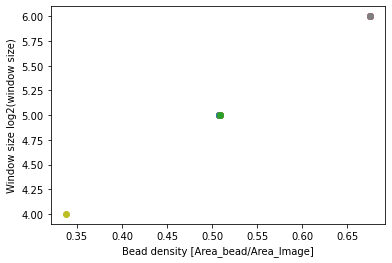

In [109]:
for x0, y0 in zip(x,y):
    plt.scatter(x0,np.log2(y0))

plt.ylabel('Window size log2(window size)')
plt.xlabel('Bead density [Area_bead/Area_Image]')

plt.show()

In [185]:
files = glob.glob('../data/TFM/aki/*.tif')
aki_ref = [x for x in files if '-ref' in x]
xaki = []
for ref_path in aki_ref:
    img_path = ref_path.replace('-ref','')
    
    traction_config = TractionForceConfig(pix_per_mu, E=E)
    img2, ref2, _ = traction_config.load_data(img_path, ref_path)
    
    x1 = np.array([density(img2[i,0,:,:], window_size=16) for i in range(img2.shape[0])])
    xaki.append(x1)
    
data1 = np.concatenate(xaki)

files = glob.glob('../data/TFM/greenhalgh-pytraction-test-data/*Position*.tif')
andrea_ref = [x for x in files if '-ref' in x]
xandrea = []
for ref_path in andrea_ref:
    img_path = ref_path.replace('-ref','')
    
    traction_config = TractionForceConfig(pix_per_mu, E=E)
    img1, ref1, _ = traction_config.load_data(img_path, ref_path)
    
    x1 = np.array([density(img1[i,0,:,:], window_size=64) for i in range(img1.shape[0])])
    xandrea.append(x1)

data2 = np.concatenate(xandrea)
    
files = glob.glob('../data/TFM/axons/*.tif')
ryan_ref = [x for x in files if '_ref' in x]
xryan = []
for ref_path in ryan_ref:
    img_path = ref_path.replace('_ref','')
    
    
    traction_config = TractionForceConfig(pix_per_mu, E=E)
    img1, ref1, _ = traction_config.load_data(img_path, ref_path)
    
    x1 = np.array([density(img1[i,0,:,:], window_size=32) for i in range(img1.shape[0])])
    xryan.append(x1)

data3 = np.concatenate(xryan)


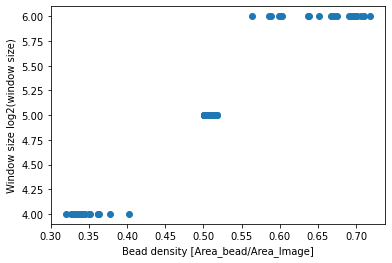

In [186]:
x, y = np.concatenate([data1,data2,data3]).T
plt.scatter(x,np.log2(y))
plt.ylabel('Window size log2(window size)')
plt.xlabel('Bead density [Area_bead/Area_Image]')

plt.show()

In [187]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

X_train = [[x] for x in X_train]
X_test = [[x] for x in X_test]

X = [[a] for a in x]

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)

y_pred = neigh.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[ 7,  0,  0],
       [ 0, 76,  0],
       [ 0,  0,  5]])

In [189]:
import pickle
with open('nn_model.pickle', 'wb') as f:
    pickle.dump(neigh, f)


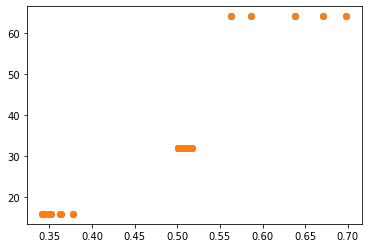

In [177]:
plt.scatter(X_test, y_test)
plt.scatter(X_test, y_pred)


In [193]:
neigh.predict([[0.5078963156408809]])
# X_test[0]

array([32.])